In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd

import sys
sys.path.append('../../')
from parameters import *
from pipelines import *

from sklearn import preprocessing

import os

#import pydpc

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata = scp.read("data/qc.h5ad")

# Parameters to control de repetition of the analysis

The following variables activate the parts of the code that are used to generate the annotation files to be employed to annotate the clusters. 

Set it to `True` if you want to make new clusterings and anotations. Set them to `False` otherwise.

If the analysis in the previous steps has been performed with the default parameters, setting the reclustering to `True` shouldn't change anything at all.

In [3]:
recluster = False
redo_annotation_files = False
reannotate = True

folder = "./Results/"
annotation_file = "Annotation_2022_03.csv"
annotation_excel = "Annotation_2022_03.xlsx"

# Clustering

Following the same reasoning as previously stated, we perfrom the clustering and annotation over each time point independently.

We cluster the different stages using a the following algorithms:

1. Louvain


In [4]:
if recluster:
    #Compute clustering by batches
    louvain_batches(adata,
                   neighbors_key = "Neighbors_Stage",
                   resolution = LOUVAIN_RESOLUTION)
    #Save obs
    d = adata.obs.loc[:,["Cell","Louvain_Stage"]]
    d["Annotation_Stage"] = ""
    d.to_csv(folder+"Annotation.csv")
else:
    #Load cluters
    clusters_file = pd.read_csv(folder+annotation_file)
    #Find common cells
    d = pd.merge(adata.obs.loc[:,"Cell"], clusters_file, how='inner',on=["Cell"]).loc[:,["Cell","Louvain_Stage","Annotation_Stage"]].set_index("Cell")
    #Set index by cell
    adata.obs.set_index("Cell",inplace=True)
    #Assign clusters to common cells in new and old clusters
    adata.obs.loc[d.index,"Louvain_Stage"] = d.loc[:,"Louvain_Stage"].values.astype(str)
    #Assign annotations to common cells
    adata.obs.loc[d.index,"Annotation_Stage"] = d.loc[:,"Annotation_Stage"].values.astype(str)
    #Reset original index
    adata.obs.reset_index(inplace=True)

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

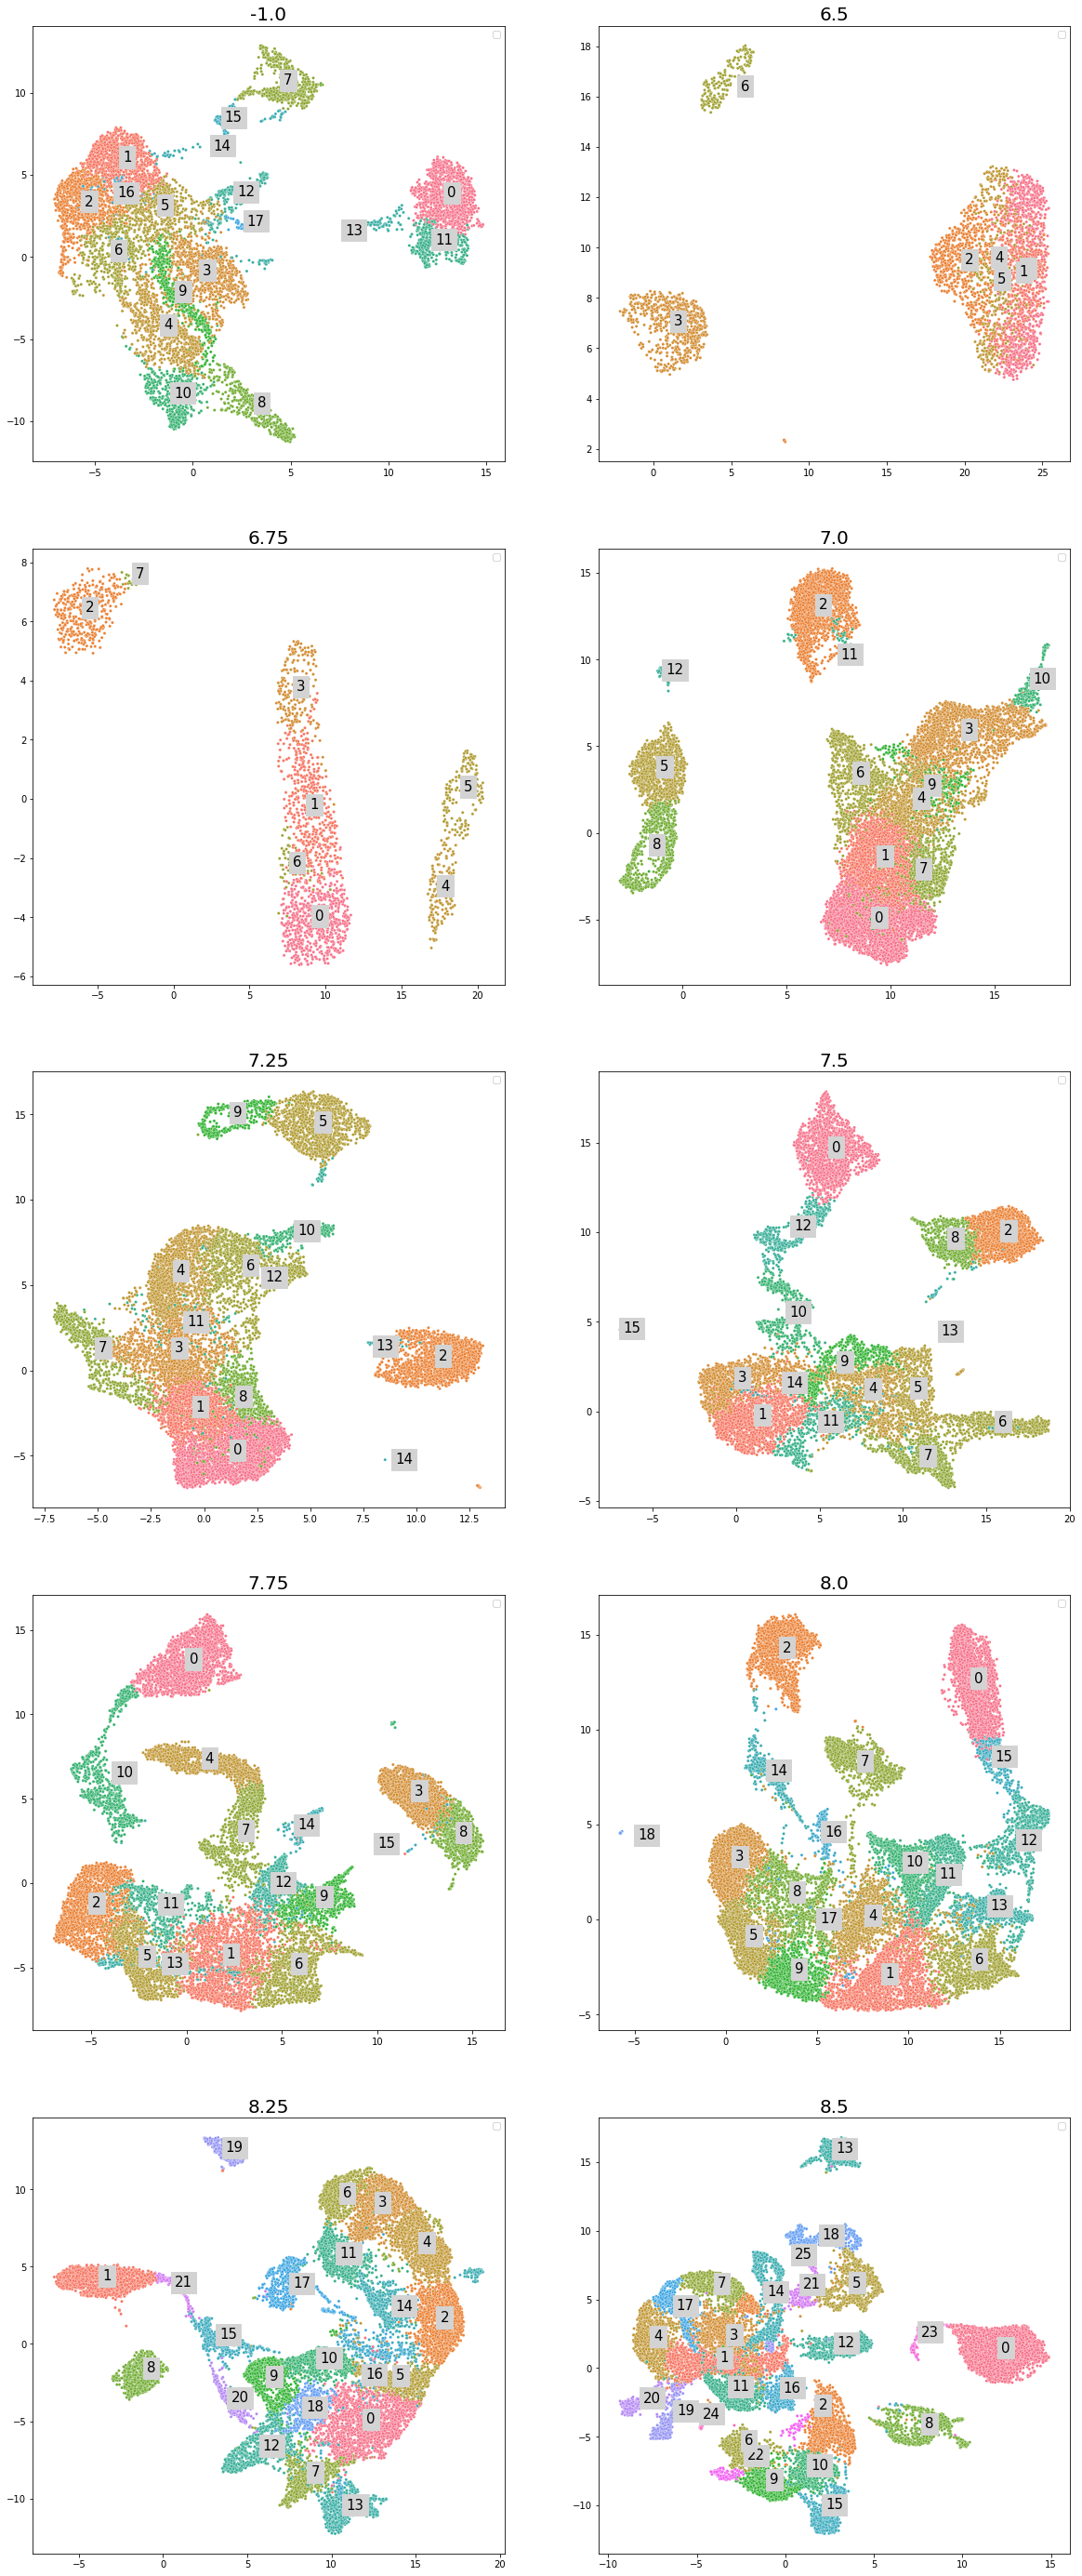

In [6]:
clustering_algorithm = "Louvain_Stage"
representation = "X_umap_Stage"

fig,ax = plt.subplots(5,2,figsize=[20,50])

for j,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())):
    
    posx = j//2
    posy = j%2
    
    l = adata.obs.loc[:,"Stage_numeric"]==stage    

    t = adata.obs.loc[l,clustering_algorithm].astype(str)
        
    sns.scatterplot(adata.obsm[representation][l,0],adata.obsm[representation][l,1],hue=adata.obs.loc[l,clustering_algorithm].values,s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(stage,fontsize=20)
    for k in t.unique():
        if k != "nan":
            pos = adata.obsm[representation][l,:][t==k,:]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            ax[posx,posy].text(pos[0],pos[1],k,fontsize=15,backgroundcolor="lightgrey")
    ax[posx,posy].legend([])
            
fig.savefig("Plots/2_"+clustering_algorithm+"_clusters.png",bbox_inches="tight",transparent=True)

## Doublet scores by cluster

In order to check if the clusters are biologically relevant, we check the distribution of doublet expression in those clusters. We can see that several clusters contain a specially high level of doublet expression in comparison with the average. Marking those clusters that clusters that are 2 standard deviations over the average doublet score per cluster, we see that the majority of those clusters are small populations of outliers or belong to regions between clusters, as can be clearly seen in stages "E8.25" and "E8.5". The presence of these clusters with atypical overexpression of doublet scores may indicate that we did not remove all possible doublets from the dataset.

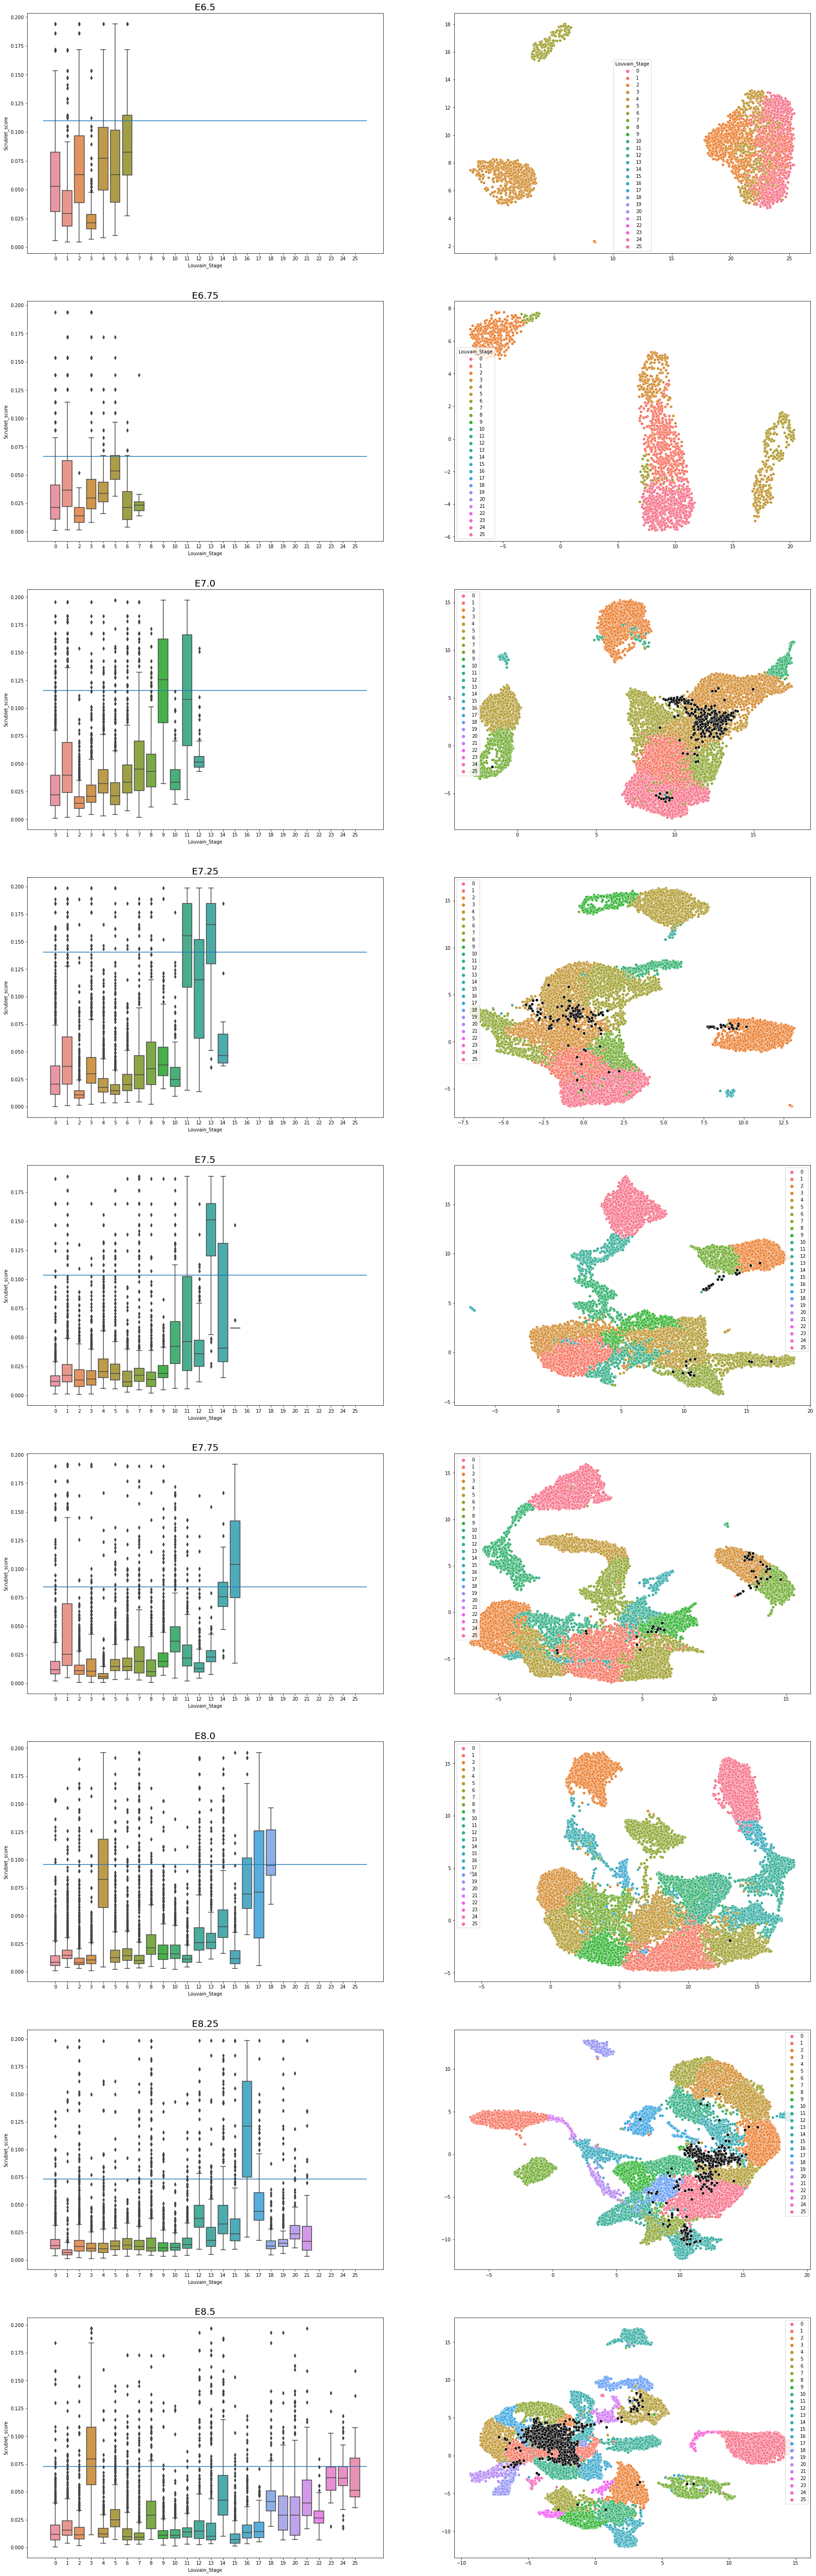

In [7]:
fig,ax = plt.subplots(9,2,figsize=[30,100])

n_std = 2

for i,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())[1:]):
    
    l = adata.obs["Stage_numeric"] == stage
    d = adata.obs.loc[l,["Stage","Louvain_Stage","Scrublet_score"]] 
        
    sns.boxplot(data=d,x="Louvain_Stage",y="Scrublet_score",ax=ax[i,0])
    ax[i,0].set_title("E"+str(stage),fontsize=20)
    
    v = d.groupby("Louvain_Stage").mean()
    sns.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],adata.obs.loc[l,"Louvain_Stage"],ax=ax[i,1])
    limit = v["Scrublet_score"].mean()+n_std*v["Scrublet_score"].std()
    m = v[v["Scrublet_score"]>limit].index.values
    
    ax[i,0].hlines(limit,-1,v.shape[0])
    
    for cluster in m:
        l2 = adata.obs["Louvain_Stage"] == cluster
        l2 *= l
        sns.scatterplot(adata.obsm["X_umap_Stage"][l2,0],adata.obsm["X_umap_Stage"][l2,1],color="black",ax=ax[i,1])
        
fig.savefig("./Plots/2_Clusters_with_high_dobulet_expression.png",bbox_inches="tight",transparent=True)

# Annotation

The manual annotation is performed over each stage independently.

For the manual annotation we use the following information:

1. A list of Differentially Expressed genes of each cluster vs. the rest.
2. Plots of gene expression over the UMAP for characteristic genes (list to be found in parameters.py).

## Create files for manual annotation

In [8]:
#Set old annotations to none if there is not a previous annotation of the cells.
if redo_annotation_files:

    rank_genes_excel(adata)
    plot_genes(adata)
    make_empty_annotation(adata,old_annotations=annotations)

## Annotate dataset

Once the annotation is performed, we add the information to the dataset and generate the plots with the labelled clusters.

In [9]:
if reannotate:
    ann = pd.read_excel(folder+annotation_excel,sheet_name=None)
    adata.obs["Annotation_Stage"] = ""

    for stage in adata.obs["Stage"].unique():
        b = adata[adata.obs["Stage"]==stage]
        
        for cluster in b.obs["Louvain_Stage"].unique():
            if type(cluster) == str:
                kk = int(cluster)
                adata.obs.loc[b.obs[b.obs["Louvain_Stage"]==cluster].index,"Annotation_Stage"] = ann[stage].loc[kk,"simplified_new_annotation"]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

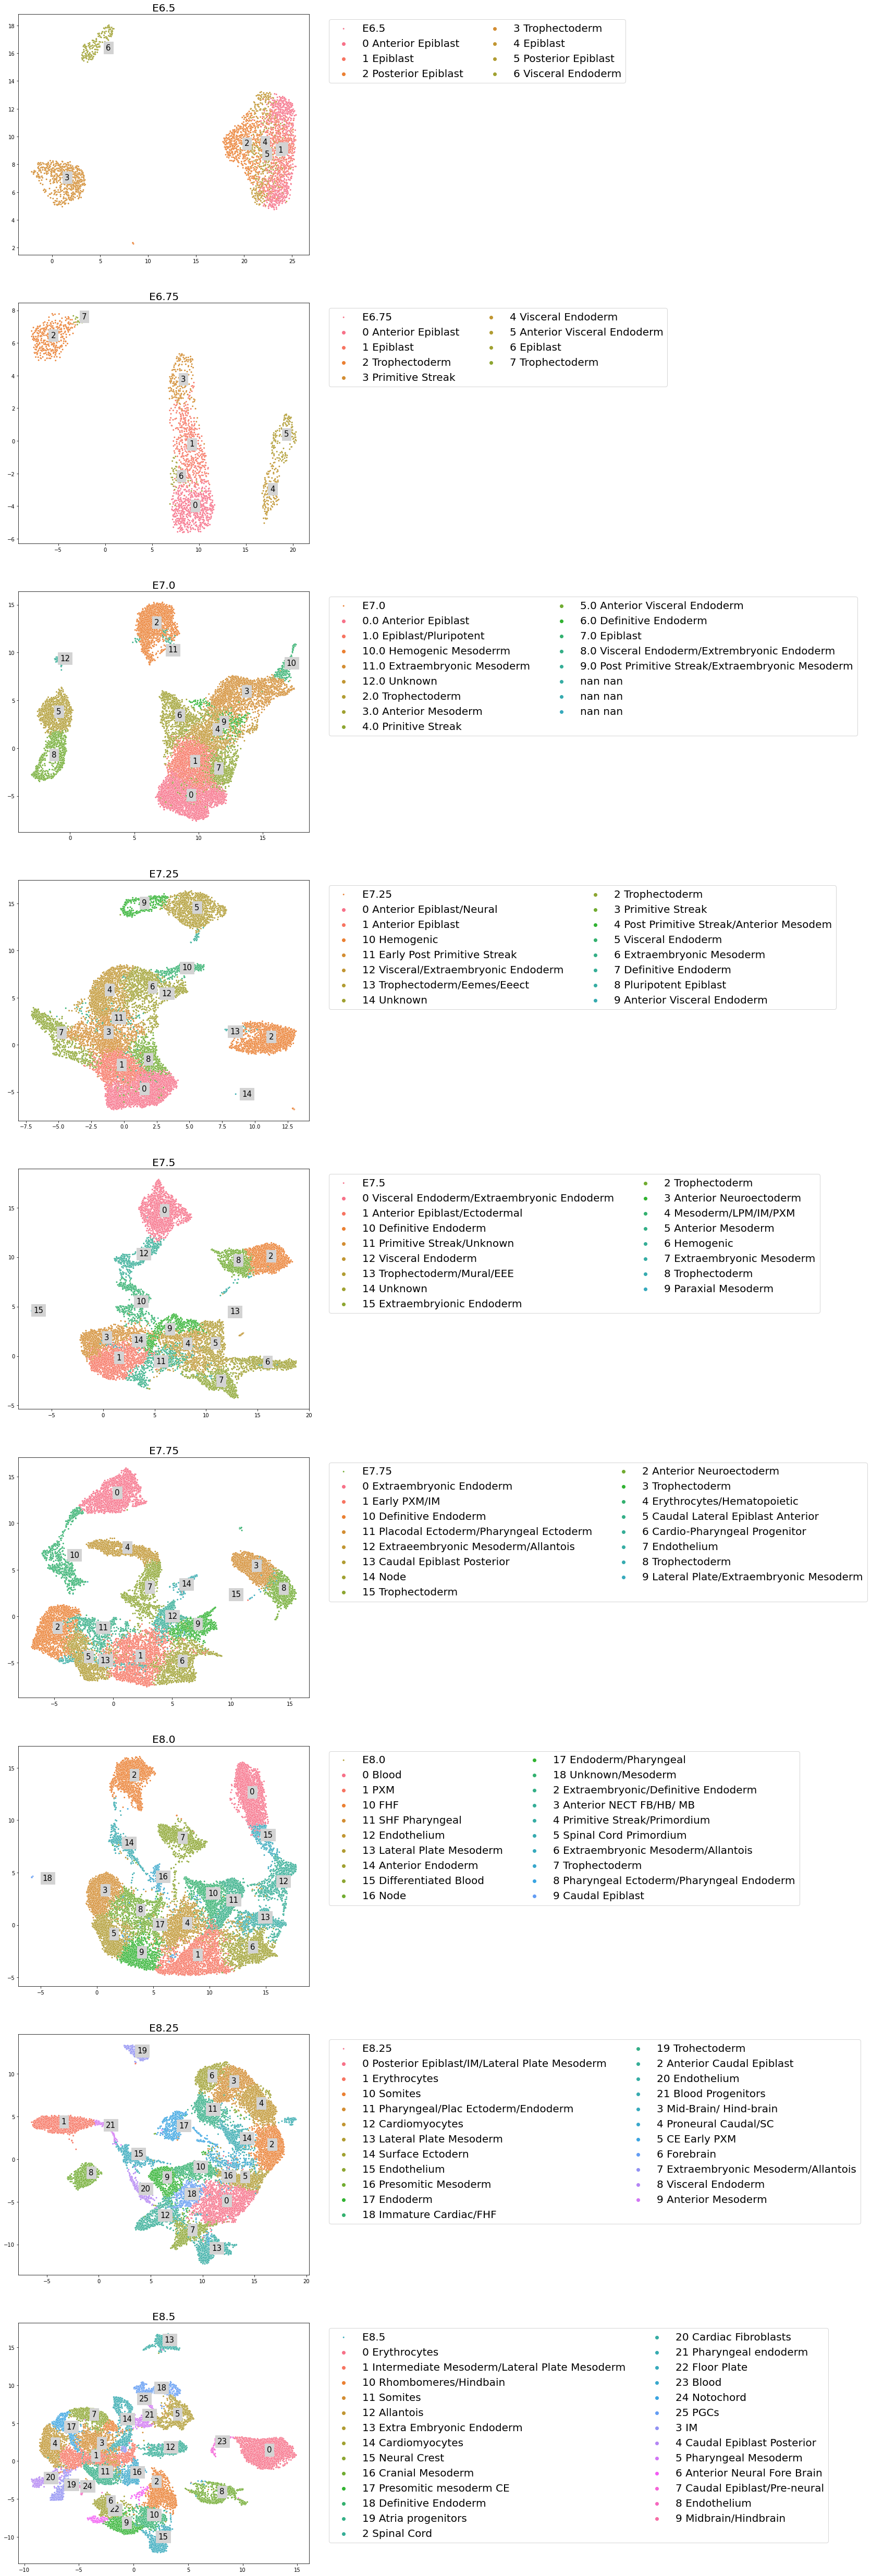

In [10]:
clustering_algorithm = "Louvain_Stage"
representation = "X_umap_Stage"

ann = pd.read_excel(folder+annotation_excel,sheet_name=None)

fig1,ax1 = plt.subplots(9,figsize=[10,90])

for j,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())[1:]):
        
    l = adata.obs.loc[:,"Stage_numeric"]==stage    
    t = adata.obs.loc[l,clustering_algorithm].astype(str)
        
    sns.scatterplot(adata.obsm[representation][l,0],adata.obsm[representation][l,1],hue=adata.obs.loc[l,clustering_algorithm].values,s=10,ax=ax1[j])
    ax1[j].set_title("E"+str(stage),fontsize=20)
    for k in t.unique():
        if k != "nan":
            pos = adata.obsm[representation][l,:][t==k,:]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            ax1[j].text(pos[0],pos[1],k,fontsize=15,backgroundcolor="lightgrey")
        
    stage = "E"+str(stage)
    ax1[j].legend([stage,]+[str(i)+" "+str(j) for i,j in zip(ann[stage].loc[:,"cluster"],ann[stage].loc[:,"simplified_new_annotation"])],
                    bbox_to_anchor=(1.05, 1),
                    fontsize=20,
                    ncol=2)
    
fig1.savefig("./Plots/2_Louvain_clusters_annotated.png",bbox_inches="tight",transparent=True)

## Comparing our annotations with previous annotations from Pijuan-Sala

The dataset was previously annotated by the authors of the dataset. In order to check the potential discrepancies between annotations:

 1. We make comparative plots of the annotations (each column adds to one).
 2. Plots of their clusters and annotations over our representation.

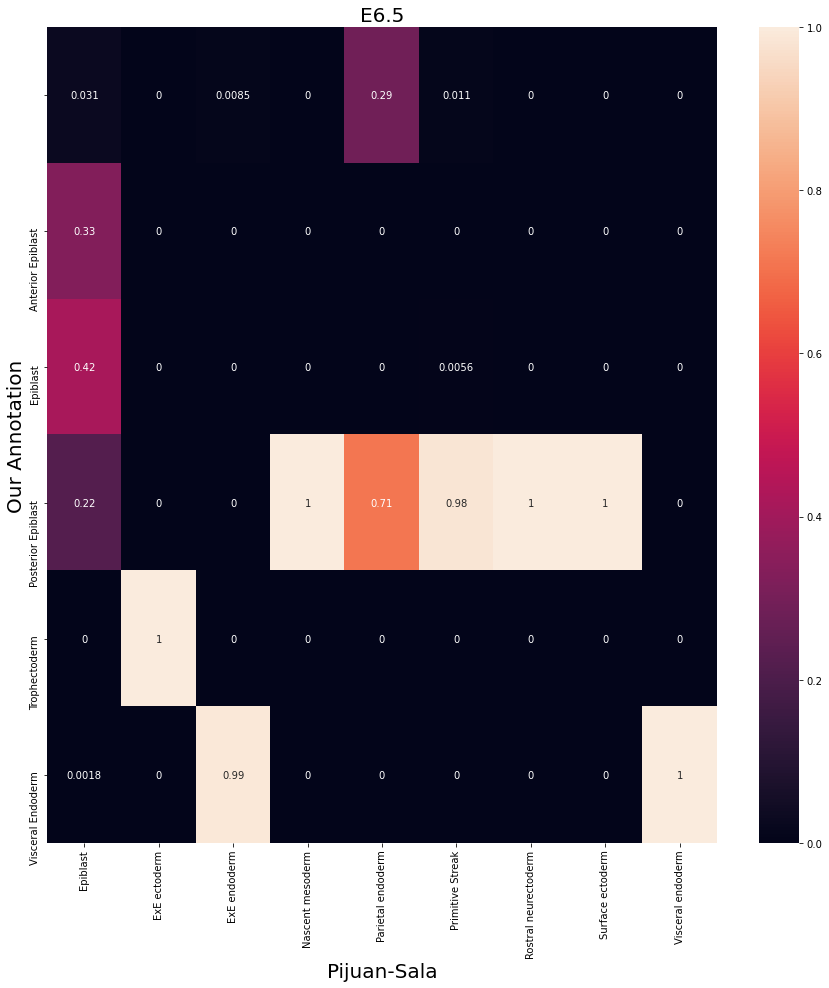

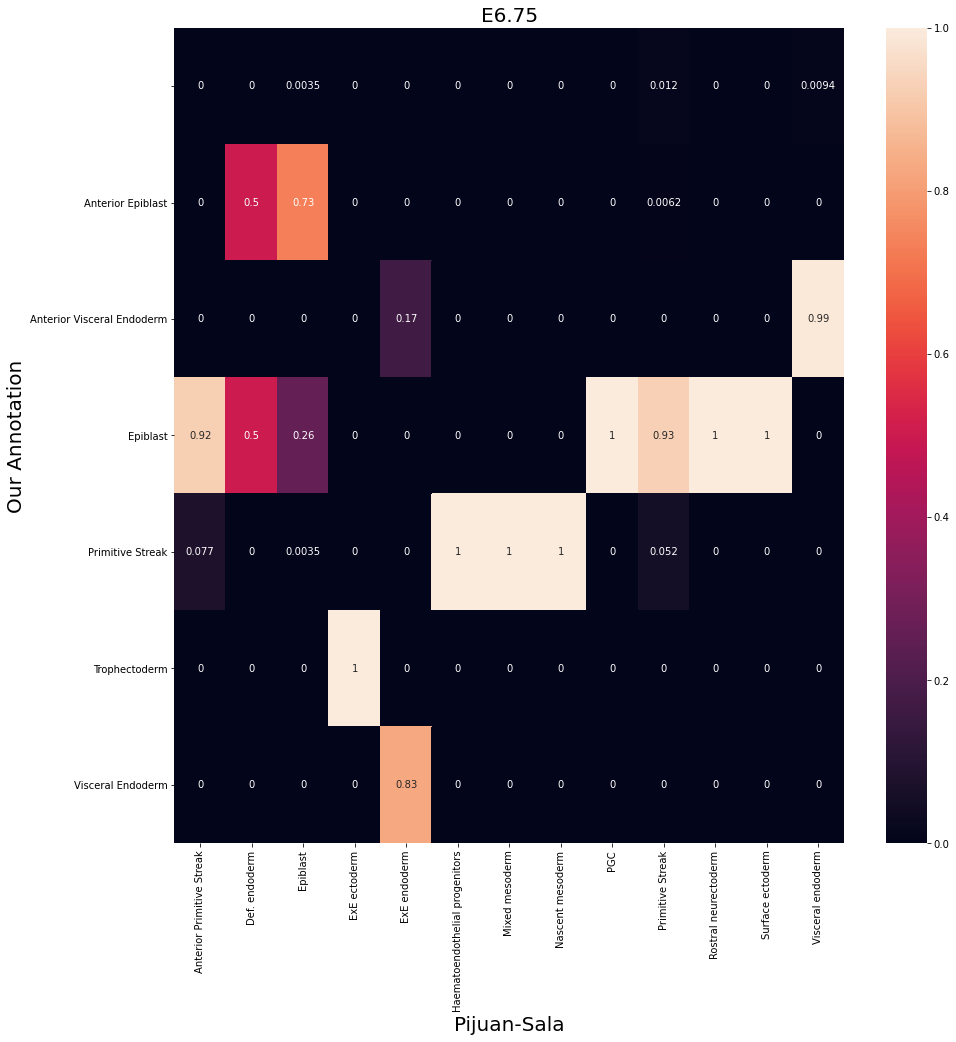

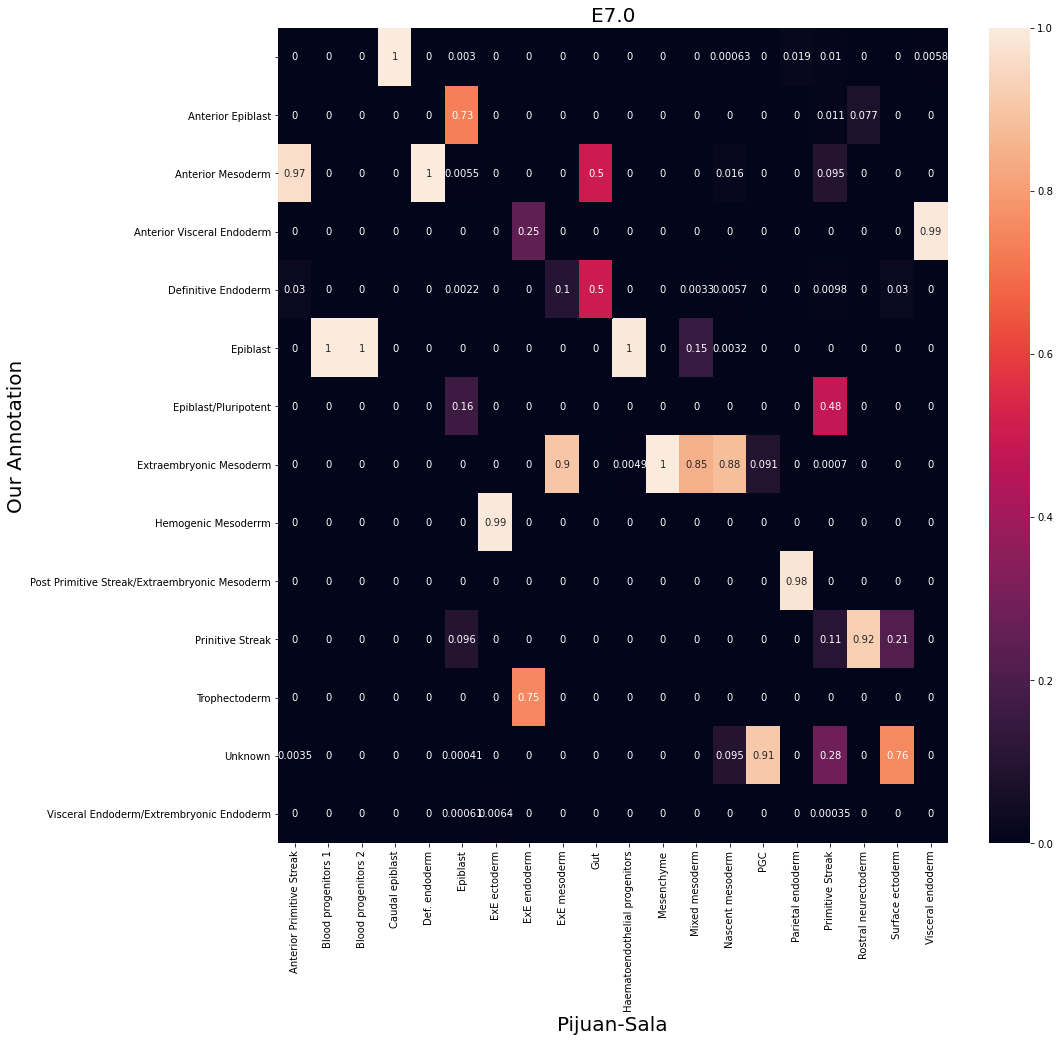

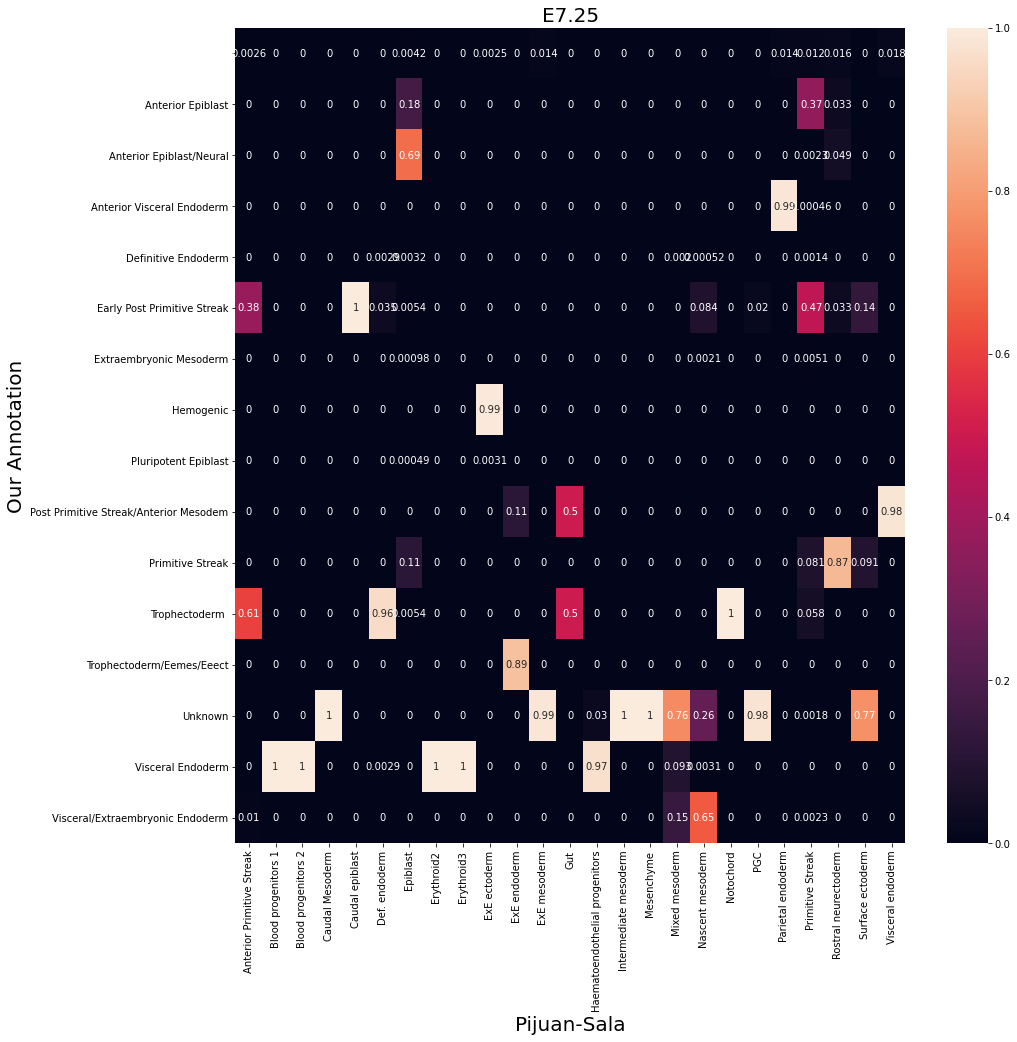

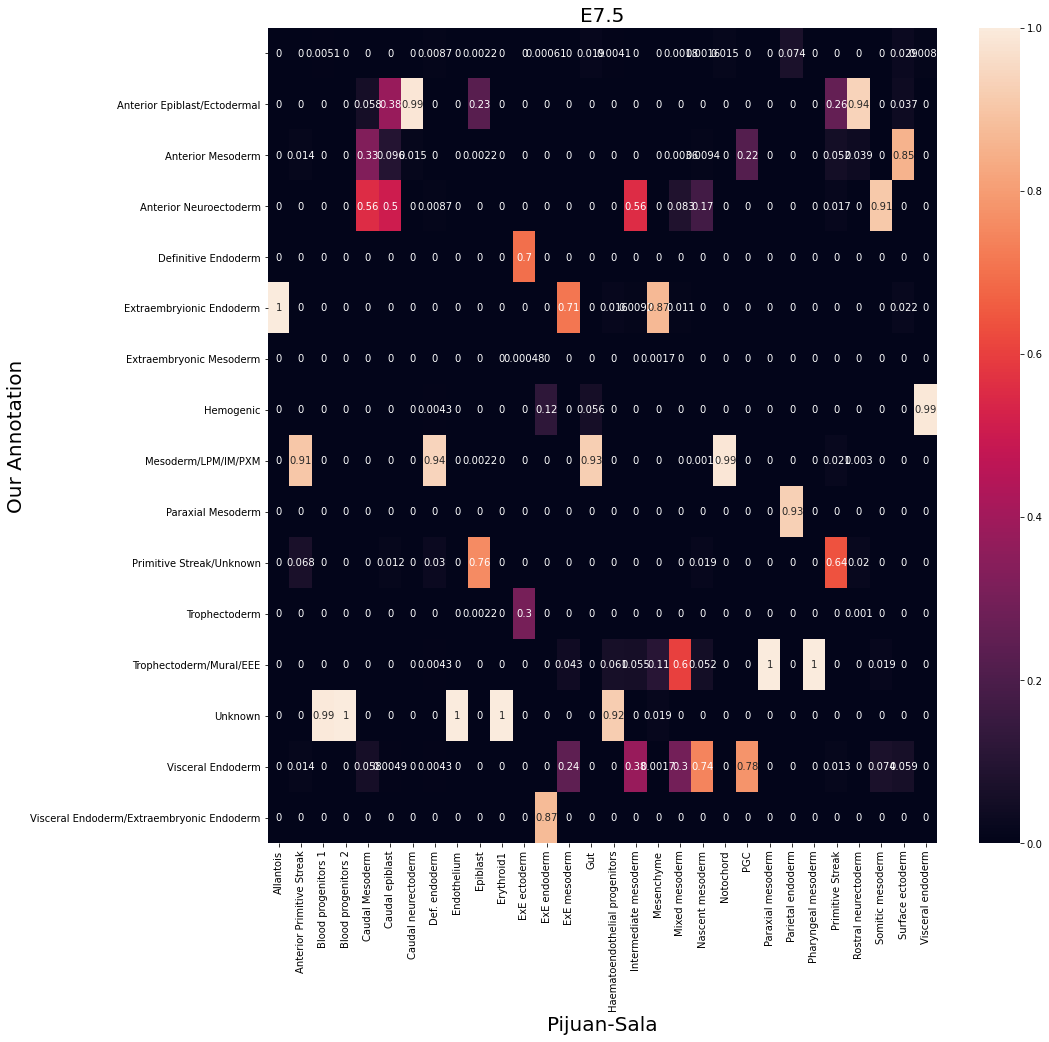

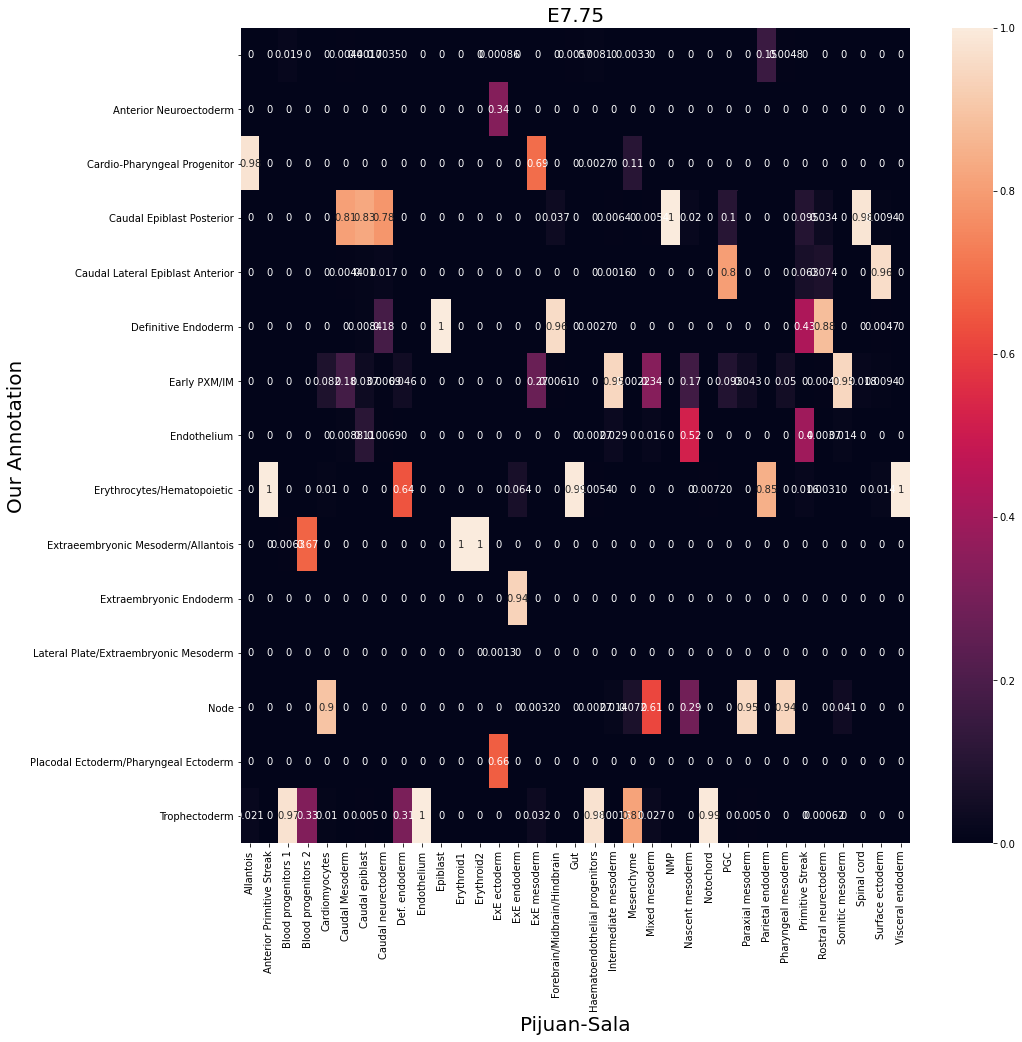

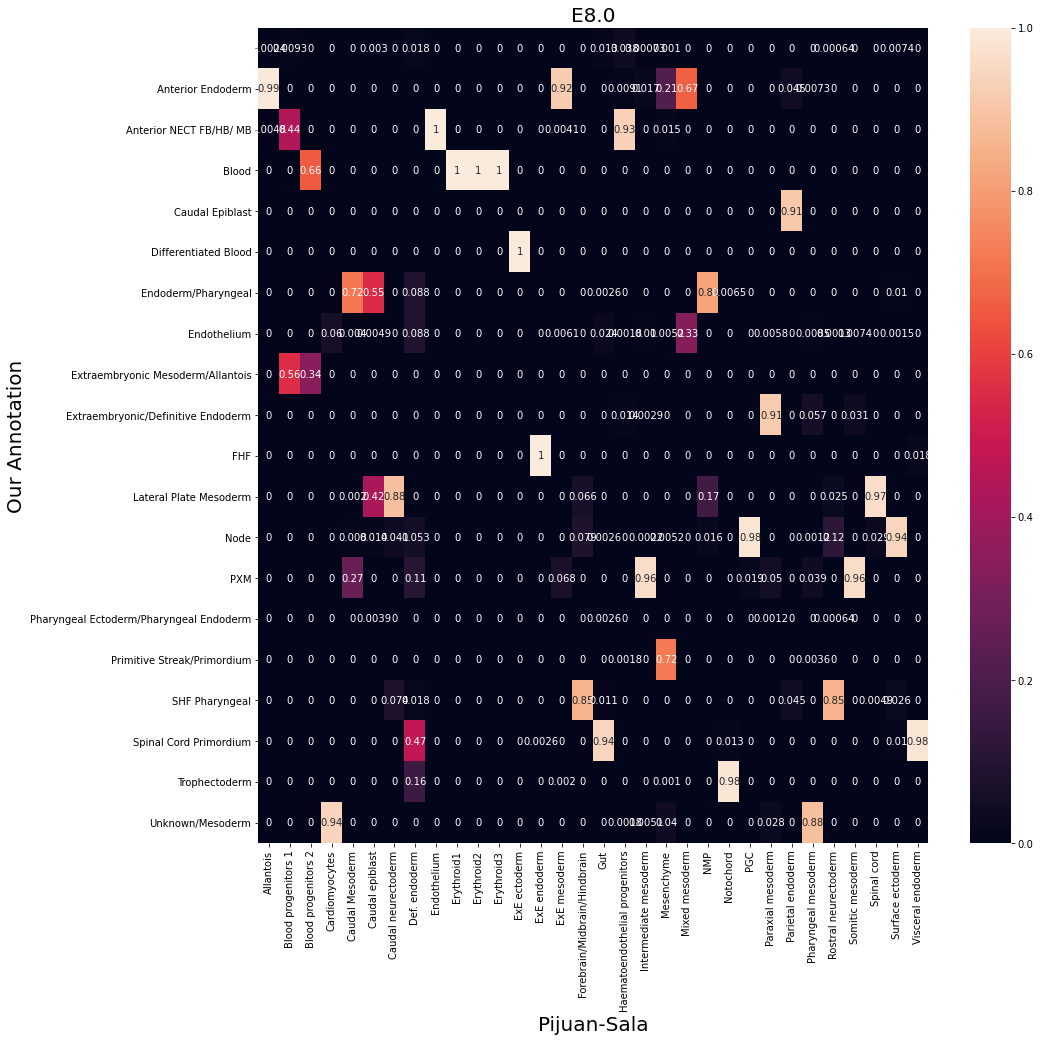

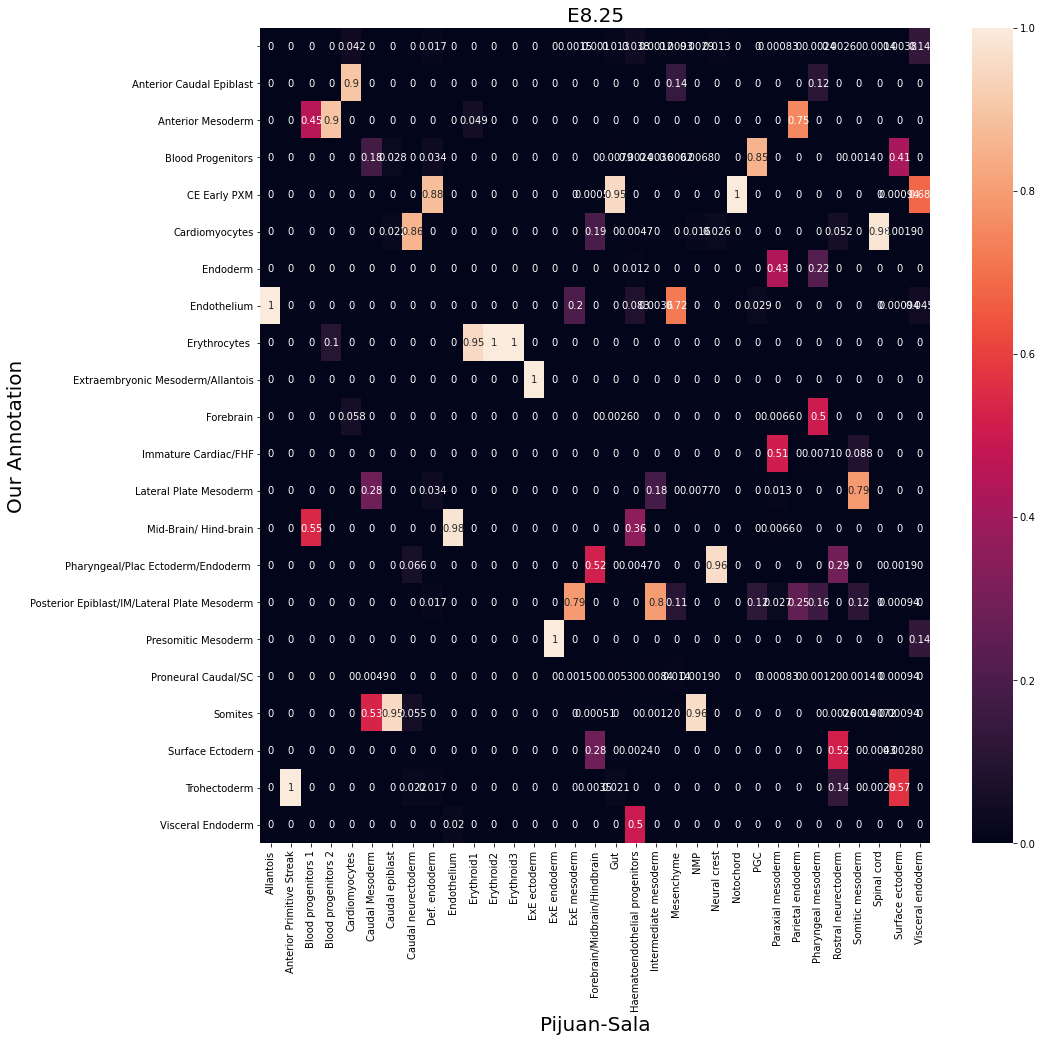

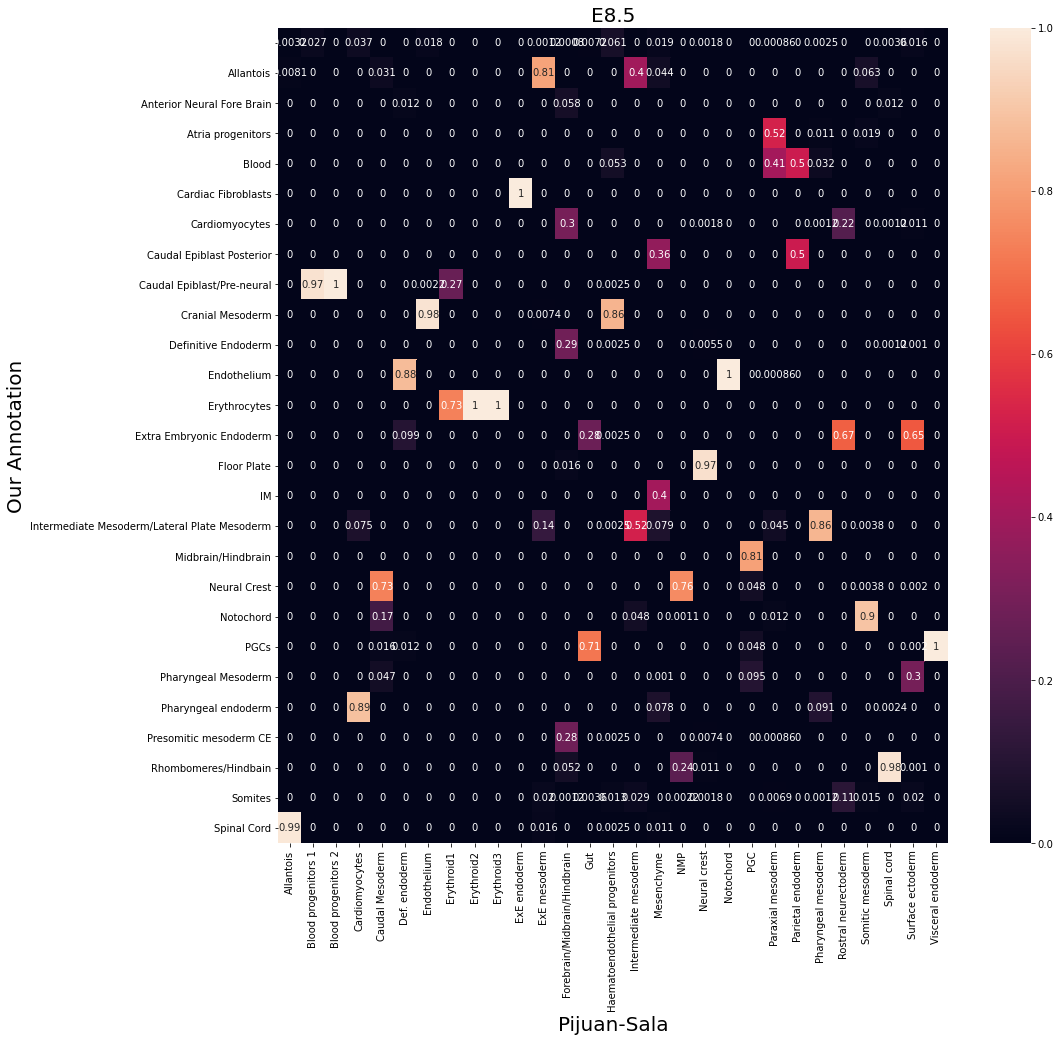

In [11]:
d = pd.read_csv("data/raw/meta.tab",sep="\t")
d.columns.values[0] = "Cell"
d = pd.merge(d,adata.obs,on="Cell").loc[:,["celltype","Annotation_Stage","Stage_numeric"]]

for i,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())[1:]):
    
    d2 = d[d["Stage_numeric"]==stage]
    
    d2 = d2.groupby(["Annotation_Stage","celltype"]).count().unstack().fillna(0)
    d2 /= d2.sum(axis=0)
    d2.columns = [i[-1] for i in d2.columns.values]

    fig, ax = plt.subplots(figsize=[15,15])
    
    sns.heatmap(d2,ax=ax,annot=True)
    ax.set_xlabel("Pijuan-Sala",fontsize=20)
    ax.set_ylabel("Our Annotation",fontsize=20)
    ax.set_title("E"+str(stage),fontsize=20)
    
    fig.savefig("./Plots/2_Pijuan_annotated_E"+str(stage)+".png",bbox_inches="tight",transparent=True)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

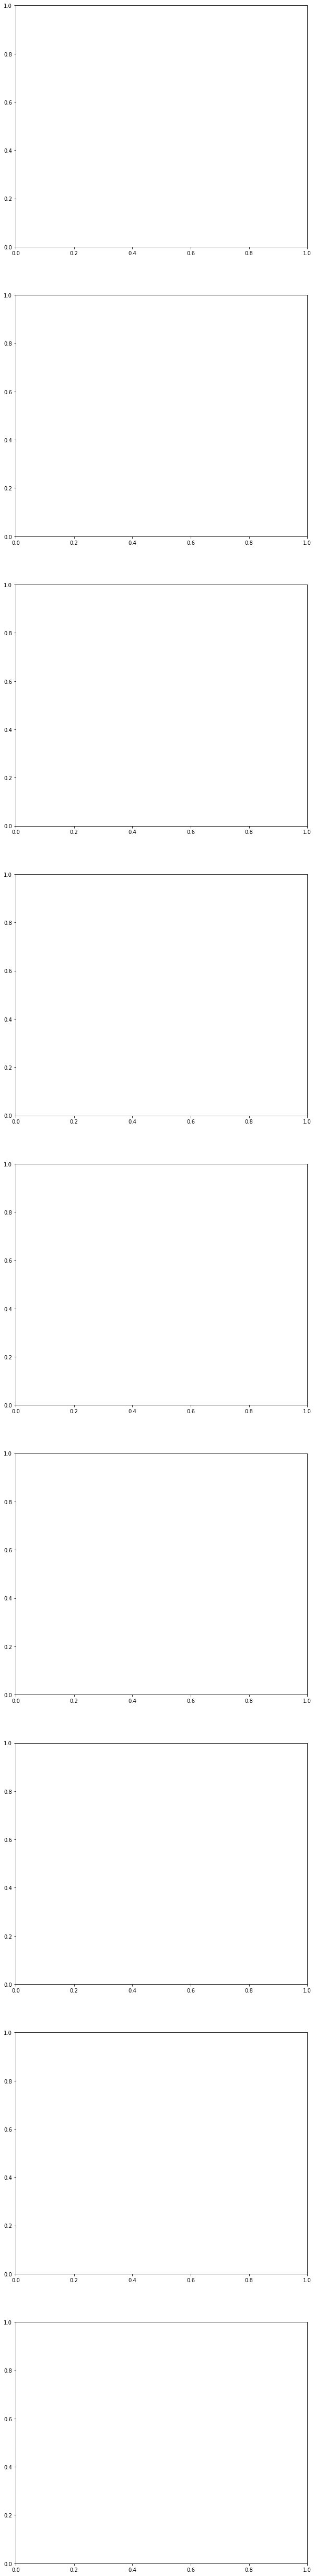

In [12]:
clustering_algorithm = "Louvain_Stage"
representation = "X_umap_Stage"

d = pd.read_csv("data/raw/meta.tab",sep="\t")
d.columns.values[0] = "Cell"
d = pd.merge(d,adata.obs,on="Cell").loc[:,["cluster","celltype","Annotation_Stage","Stage_numeric"]]

fig1,ax1 = plt.subplots(9,figsize=[10,90])

for j,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())[1:]):
        
    l = adata.obs.loc[:,"Stage_numeric"]==stage    
    t = d.loc[l,"celltype"].astype(str)
        
    sns.scatterplot(adata.obsm[representation][l,0],adata.obsm[representation][l,1],hue=d.loc[l,"celltype"].values,s=10,ax=ax1[j])
    ax1[j].set_title("E"+str(stage),fontsize=20)
    legend = []
    for kk,k in enumerate(t.unique()):
        n = np.sum(t==k)
        if k != "nan" and n > 50:
            pos = adata.obsm[representation][l,:][t==k,:]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            ax1[j].text(pos[0],pos[1],kk,fontsize=15,backgroundcolor="lightgrey")
            legend.append(str(kk)+" "+k)
        
    ax1[j].legend(legend,
                    bbox_to_anchor=(1.05, 1),
                    fontsize=20,
                    ncol=2)
    
fig1.savefig("./Plots/2_Pijuan_annotated.png",bbox_inches="tight",transparent=True)

In [ ]:
adata.write("data/qc.h5ad");